<a href="https://colab.research.google.com/github/anthonysimonIsCoding/lstm-en-fr/blob/main/lstm-en-fr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!python3 --version

Python 3.12.12


**Tải các thư viện cần thiết**

In [ ]:
!pip install spacy

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

***Danh sách các thư viện sẽ được sử dụng***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import random
import time
import torch.nn.functional as F
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

Thiết lập GPU

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

Device: cuda


Thiết lại tokenizer

In [ ]:
tokenize_en = spacy.load("en_core_web_sm")
tokenize_fr = spacy.load("fr_core_news_sm")

In [ ]:
def tokenizer_en(sentence):
  return [token.text.lower()
          for token in tokenize_en(sentence)
          if not token.is_space and not token.is_punct]

def tokenizer_fr(sentence):
  return [token.text.lower()
          for token in tokenize_fr(sentence)
          if not token.is_space and not token.is_punct]

***Tiến hành phân tích dữ liệu***

In [ ]:
# Khai báo dường đẫn dữ liệu train
train_en_path = "/content/drive/MyDrive/Dataset/data/train/train.en"
train_fr_path = "/content/drive/MyDrive/Dataset/data/train/train.fr"
# Dữ liệu validation
val_en_path = "/content/drive/MyDrive/Dataset/data/val/val.en"
val_fr_path = "/content/drive/MyDrive/Dataset/data/val/val.fr"
# Dữ liệu test sử dụng tạp test 2016 flick
test_en_path = "/content/drive/MyDrive/Dataset/data/test/test_2016_flickr.en"
test_fr_path = "/content/drive/MyDrive/Dataset/data/test/test_2016_flickr.fr"

In [ ]:
def load_data(en_path, fr_path):
    with open(en_path, encoding="utf-8") as f_en:
        en_lines = [line.strip() for line in f_en]

    with open(fr_path, encoding="utf-8") as f_fr:
        fr_lines = [line.strip() for line in f_fr]

    assert len(en_lines) == len(fr_lines), "EN-FR line count mismatch!"
    return en_lines, fr_lines

In [ ]:
train_en_lines, train_fr_lines = load_data(train_en_path, train_fr_path)
val_en_lines, val_fr_lines = load_data(val_en_path, val_fr_path)
test_en_lines, test_fr_lines = load_data(test_en_path, test_fr_path)
# kiểm tra câu rỗng
empty_pairs_train = [(i, e, f) for i, (e, f) in enumerate(zip(train_en_lines, train_fr_lines)) if e == "" or f == ""]
empty_pairs_val = [(i, e, f) for i, (e, f) in enumerate(zip(val_en_lines, val_fr_lines)) if e == "" or f == ""]
empty_pairs_test = [(i, e, f) for i, (e, f) in enumerate(zip(test_en_lines, test_fr_lines)) if e == "" or f == ""]

print("===TRAIN===")
print(f"Tiếng Anh: {len(train_en_lines)}")
print(f"Tiếng Pháp: {len(train_fr_lines)}")
print(f"Tổng: {len(train_en_lines) + len(train_fr_lines)}")
print(f"Cặp bị rỗng:{len(empty_pairs_train)}\n")

print("===VALIDATION===")
print(f"Tiếng Anh: {len(val_en_lines)}")
print(f"Tiếng Pháp: {len(val_fr_lines)}")
print(f"Tổng: {len(val_en_lines) + len(val_fr_lines)}")
print(f"Cặp bị rỗng:{len(empty_pairs_val)}\n")

print("===TEST===")
print(f"Tiếng Anh: {len(test_en_lines)}")
print(f"Tiếng Pháp: {len(test_fr_lines)}")
print(f"Tổng: {len(test_en_lines) + len(test_fr_lines)}")
print(f"Cặp bị rỗng:{len(empty_pairs_test)}\n")

===TRAIN===
Tiếng Anh: 29000
Tiếng Pháp: 29000
Tổng: 58000
Cặp bị rỗng:0

===VALIDATION===
Tiếng Anh: 1014
Tiếng Pháp: 1014
Tổng: 2028
Cặp bị rỗng:0

===TEST===
Tiếng Anh: 1000
Tiếng Pháp: 1000
Tổng: 2000
Cặp bị rỗng:0



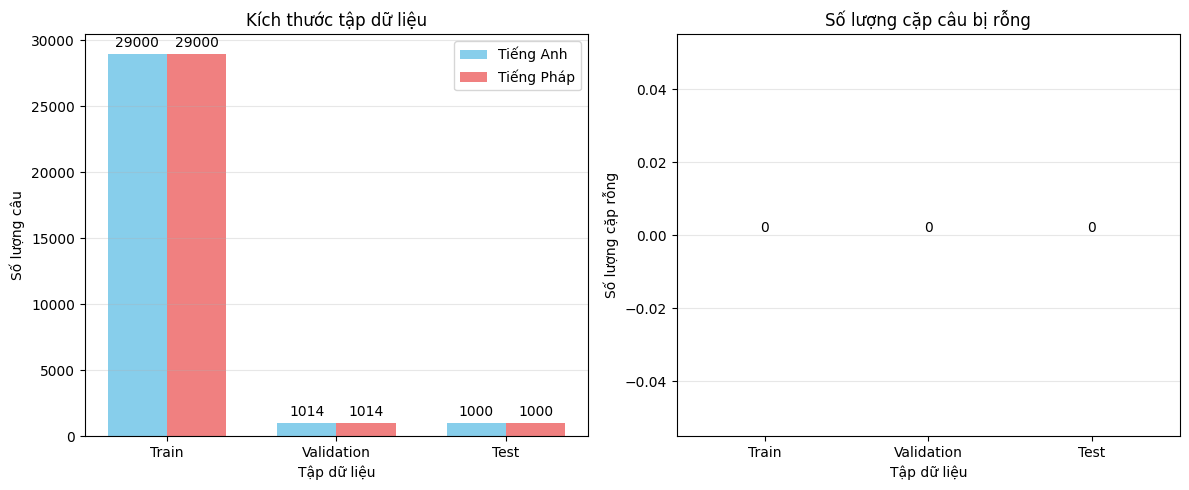

In [ ]:
# Dữ liệu cho kích thước tập dữ liệu
sets = ['Train', 'Validation', 'Test']
en_lengths = [len(train_en_lines), len(val_en_lines), len(test_en_lines)]
fr_lengths = [len(train_fr_lines), len(val_fr_lines), len(test_fr_lines)]

# Dữ liệu cho cặp rỗng
empty_counts = [len(empty_pairs_train), len(empty_pairs_val), len(empty_pairs_test)]

# Tạo figure với 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: Kích thước tập dữ liệu (EN và FR)
x = np.arange(len(sets))
width = 0.35

ax1.bar(x - width/2, en_lengths, width, label='Tiếng Anh', color='skyblue')
ax1.bar(x + width/2, fr_lengths, width, label='Tiếng Pháp', color='lightcoral')
ax1.set_xlabel('Tập dữ liệu')
ax1.set_ylabel('Số lượng câu')
ax1.set_title('Kích thước tập dữ liệu')
ax1.set_xticks(x)
ax1.set_xticklabels(sets)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Thêm giá trị lên thanh
for i in range(len(sets)):
    ax1.text(i - width/2, en_lengths[i] + max(en_lengths)*0.01, str(en_lengths[i]),
             ha='center', va='bottom')
    ax1.text(i + width/2, fr_lengths[i] + max(fr_lengths)*0.01, str(fr_lengths[i]),
             ha='center', va='bottom')

# Subplot 2: Số lượng cặp rỗng
colors = ['red' if count > 0 else 'green' for count in empty_counts]
ax2.bar(sets, empty_counts, color=colors, alpha=0.7)
ax2.set_xlabel('Tập dữ liệu')
ax2.set_ylabel('Số lượng cặp rỗng')
ax2.set_title('Số lượng cặp câu bị rỗng')
ax2.grid(axis='y', alpha=0.3)

# Thêm giá trị lên thanh
for i, count in enumerate(empty_counts):
    ax2.text(i, count + max(empty_counts)*0.01 if count > 0 else 0, str(count),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Xem xét độ dài câu (token)
def get_lengths(sentences, tokenizer):
    return [len(tokenizer(s)) for s in sentences]

train_len_en = get_lengths(train_en_lines, tokenize_en)
train_len_fr = get_lengths(train_fr_lines, tokenize_fr)

val_len_en = get_lengths(val_en_lines, tokenize_en)
val_len_fr = get_lengths(val_fr_lines, tokenize_fr)

test_len_en = get_lengths(test_en_lines, tokenize_en)
test_len_fr = get_lengths(test_fr_lines, tokenize_fr)

In [ ]:
import numpy as np

def length_stats(lengths, name):
    print(f"--- {name} ---")
    print("Min:", np.min(lengths))
    print("Max:", np.max(lengths))
    print("Mean:", np.mean(lengths))
    print("Median:", np.median(lengths))

length_stats(train_len_en, "Train EN")
length_stats(train_len_fr, "Train FR")

length_stats(val_len_en, "Validate EN")
length_stats(val_len_fr, "Validate FR")

length_stats(test_len_en, "Test EN")
length_stats(test_len_fr, "Test FR")

--- Train EN ---
Min: 4
Max: 41
Mean: 13.11
Median: 12.0
--- Train FR ---
Min: 4
Max: 54
Mean: 14.278103448275862
Median: 13.0
--- Validate EN ---
Min: 4
Max: 32
Mean: 13.240631163708088
Median: 13.0
--- Validate FR ---
Min: 5
Max: 36
Mean: 14.340236686390533
Median: 13.5
--- Test EN ---
Min: 5
Max: 33
Mean: 13.058
Median: 12.0
--- Test FR ---
Min: 6
Max: 36
Mean: 14.154
Median: 13.0


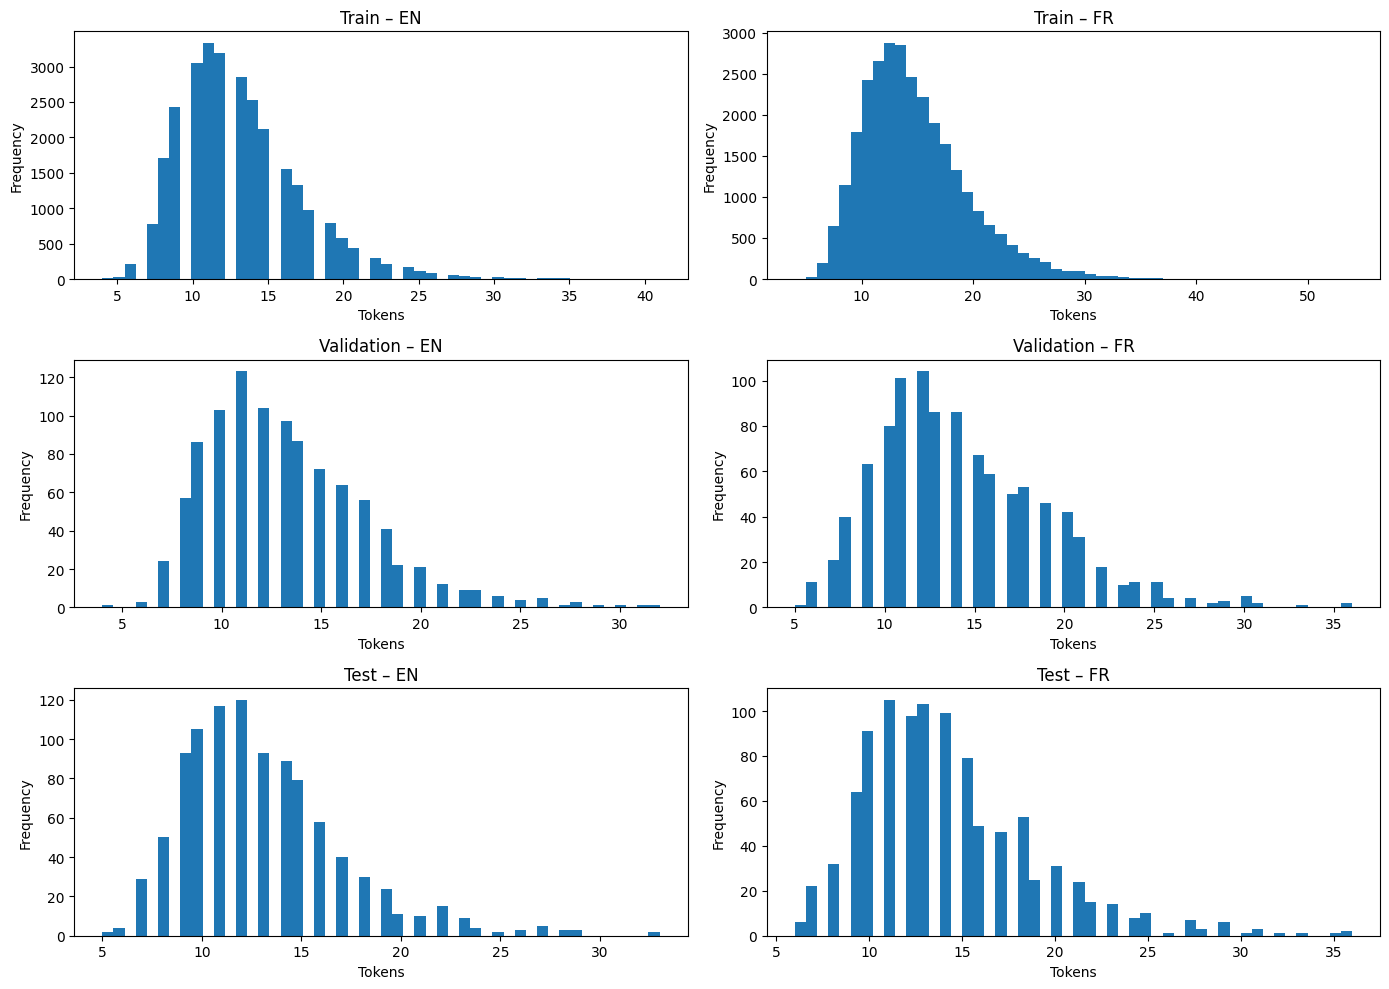

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# ===== TRAIN =====
plt.subplot(3, 2, 1)
plt.hist(train_len_en, bins=50)
plt.title("Train – EN")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(3, 2, 2)
plt.hist(train_len_fr, bins=50)
plt.title("Train – FR")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

# ===== VALIDATION =====
plt.subplot(3, 2, 3)
plt.hist(val_len_en, bins=50)
plt.title("Validation – EN")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(3, 2, 4)
plt.hist(val_len_fr, bins=50)
plt.title("Validation – FR")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

# ===== TEST =====
plt.subplot(3, 2, 5)
plt.hist(test_len_en, bins=50)
plt.title("Test – EN")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(3, 2, 6)
plt.hist(test_len_fr, bins=50)
plt.title("Test – FR")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


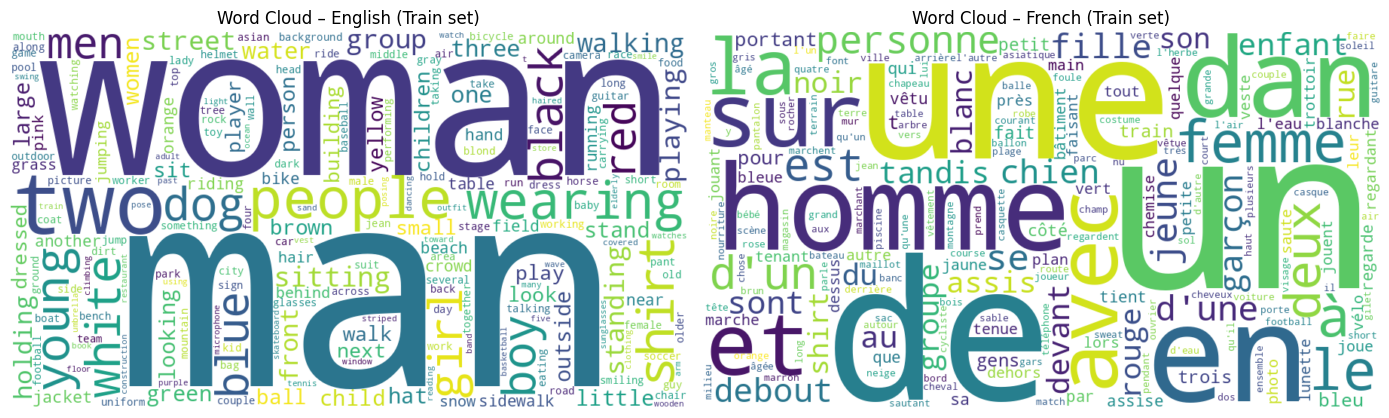

In [ ]:
def merge_corpus(sentences):
    return " ".join(s.lower() for s in sentences)

en_corpus = merge_corpus(train_en_lines)
fr_corpus = merge_corpus(train_fr_lines)

def plot_wordcloud(text, title):
    wc = WordCloud(
        width=900,
        height=500,
        max_words=200,
        background_color="white",
        collocations=False
    ).generate(text)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_wordcloud(en_corpus, "Word Cloud – English (Train set)")

plt.subplot(1, 2, 2)
plot_wordcloud(fr_corpus, "Word Cloud – French (Train set)")

plt.tight_layout()
plt.show()

Xây dựng vocabulary

In [ ]:
index_token = [
  "<pad>", #Padding giúp câu có cùng độ dài
  "<unk>", #Unknow đánh dấu từ không có nghĩa
  "<sos>", #Từ ở đầu câu
  "<eos>"  #TỪ ở cuối câu
]

PAD_IDX = index_token.index("<pad>")   # 0
UNK_IDX = index_token.index("<unk>")   # 1
SOS_IDX = index_token.index("<sos>")   # 2
EOS_IDX = index_token.index("<eos>")   # 3

In [ ]:
def build_vocab(sentences, tokenizer, max_size):
  counter = Counter()

  for sen in sentences:
    tokens = tokenizer(sen)
    counter.update(tokens)

  most_common = counter.most_common(max_size - 4)
  # Danh sách từ
  idx_token = index_token + [word for word, _ in most_common]
  # map token → id
  token_to_index = {token: idx for idx, token in enumerate(idx_token)}

  return token_to_index, index_token, counter

In [ ]:
# Build vocab
vocab_en, index_en, counter_en = build_vocab(train_en_lines, tokenizer_en, max_size=10000)
vocab_fr, index_fr, counter_fr = build_vocab(train_fr_lines, tokenizer_fr, max_size=10000)

print("EN vocab size:", len(vocab_en))
print("FR vocab size:", len(vocab_fr))

EN vocab size: 9782
FR vocab size: 10000


In [ ]:
# Đưa vocab về dạng số
def numericalize_source(sentence, tokenizer, vocab):
  tokens = tokenizer(sentence)

  if len(tokens) == 0:
    tokens = ["<unk>"]   # bảo vệ câu rỗng

  tokens = tokens + ["<eos>"]

  return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

def numericalize_target(sentence, tokenizer, vocab):
  tokens = ["<sos>"] + tokenizer(sentence) + ["<eos>"]
  return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

In [ ]:
class Translate_Dataset(torch.utils.data.Dataset):
  def __init__(self, en_sentences, fr_sentences,
                tokenizer_en, tokenizer_fr,
                vocab_en, vocab_fr):

    assert len(en_sentences) == len(fr_sentences)

    self.en_sentences = en_sentences
    self.fr_sentences = fr_sentences
    self.tokenizer_en = tokenizer_en
    self.tokenizer_fr = tokenizer_fr
    self.vocab_en = vocab_en
    self.vocab_fr = vocab_fr

  def __len__(self):
    return len(self.en_sentences)

  def __getitem__(self, index):
    source_ids = numericalize_source(
      self.en_sentences[index],
      self.tokenizer_en,
      self.vocab_en
    )

    target_ids = numericalize_target(
      self.fr_sentences[index],
      self.tokenizer_fr,
      self.vocab_fr
    )

    # length dùng cho pack_padded_sequence
    source_lengths = len(source_ids)

    return (
      torch.tensor(source_ids, dtype=torch.long),
      torch.tensor(target_ids, dtype=torch.long),
      source_lengths
    )

In [ ]:
SOURCE_PAD_IDX = vocab_en["<pad>"]
TARGET_PAD_IDX = vocab_fr["<pad>"]

def collate_fn(batch):
  source_batch, target_batch, source_lengths = zip(*batch)
  source_lengths = torch.tensor(source_lengths)
  source_lengths, sorted_idx = source_lengths.sort(descending=True)
  source_batch = [source_batch[i] for i in sorted_idx]
  target_batch = [target_batch[i] for i in sorted_idx]

  source_batch = pad_sequence(
    source_batch,
    batch_first=True,
    padding_value=SOURCE_PAD_IDX
  )

  target_batch = pad_sequence(
    target_batch,
    batch_first=True,
    padding_value=TARGET_PAD_IDX
  )

  assert source_lengths.min() > 0, "Found source length <= 0"

  return source_batch, target_batch, source_lengths

In [ ]:
# Tạo DataLoaders
train = Translate_Dataset(train_en_lines, train_fr_lines, tokenizer_en, tokenizer_fr, vocab_en, vocab_fr)
val = Translate_Dataset(val_en_lines, val_fr_lines, tokenizer_en, tokenizer_fr, vocab_en, vocab_fr)
test = Translate_Dataset(test_en_lines, test_fr_lines, tokenizer_en, tokenizer_fr, vocab_en, vocab_fr)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size=32 ,shuffle=False, collate_fn=collate_fn)

Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(
      embed_size,
      hidden_size,
      num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0,
      batch_first=True,
    )

  def forward(self, source, lengths):
    if isinstance(lengths, list):
      lengths = torch.tensor(lengths, dtype=torch.long, device=source.device)

    lengths = lengths.cpu()

    embedded = self.dropout(self.embedding(source))

    packed = nn.utils.rnn.pack_padded_sequence(
      embedded,
      lengths,
      batch_first=True,
      enforce_sorted=False
    )

    packed_outputs, (hidden, cell) = self.lstm(packed)

    outputs, _ = nn.utils.rnn.pad_packed_sequence(
        packed_outputs, batch_first=True
    )

    return outputs, (hidden, cell)

Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, pad_idx):
    super().__init__()

    self.embedding = nn.Embedding(
      vocab_size,
      embed_size,
      padding_idx=pad_idx
    )

    self.lstm = nn.LSTM(
      embed_size,
      hidden_size,
      num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0.0,
      batch_first=True
    )

    self.fc_out = nn.Linear(hidden_size, vocab_size)

  def forward(self, token, hidden, cell):
    token = token.unsqueeze(1)
    embedded = self.embedding(token)
    output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
    prediction = self.fc_out(output.squeeze(1))

    return prediction, hidden, cell

Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, pad_index):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.pad_index = pad_index

  def forward(self, source, target, source_lengths, teacher_forcing_ratio=0.5):
    batch_size, target_sequence_length = target.size()
    vocabulary_size = self.decoder.fc_out.out_features
    device = source.device

    outputs = torch.zeros(batch_size, target_sequence_length, vocabulary_size, device=device)

    encoder_outputs, (hidden_state, cell_state) = self.encoder(source, source_lengths)

    decoder_input = target[:, 0]

    for timestep in range(1, target_sequence_length):

      decoder_output, hidden_state, cell_state = self.decoder(
        decoder_input, hidden_state, cell_state
      )

      outputs[:, timestep] = decoder_output
      use_teacher_forcing = random.random() < teacher_forcing_ratio
      predicted_token = decoder_output.argmax(1)
      decoder_input = target[:, timestep] if use_teacher_forcing else predicted_token

    return outputs

Build Model

In [ ]:
# Khai báo thông số model
INPUT_SIZE = len(vocab_en)
OUTPUT_SIZE = len(vocab_fr)
ENC_EMB_SIZE = 256
DEC_EMB_SIZE = 256
HID_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
N_EPOCHS = 20
LEARNING_RATE = 0.001

In [ ]:
#  Thiết lập Early Stopping
class EarlyStopping:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.counter = 0
    self.should_stop = False

  def __call__(self, val_loss):
    # Nếu cải thiện
    if val_loss < self.best_loss - self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      print(f"No improvement ({self.counter}/{self.patience})")

      if self.counter >= self.patience:
        self.should_stop = True
        print("\n Early Stopping Triggered!")

In [ ]:
encoder = Encoder(INPUT_SIZE, ENC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
decoder = Decoder(OUTPUT_SIZE, DEC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT, PAD_IDX).to(DEVICE)
model = Seq2Seq(encoder, decoder, PAD_IDX).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer,
  mode='min',
  factor=0.5,
  patience=2,
  threshold=1e-4,
  cooldown=0,
  min_lr=1e-6,
)

Training Loop

In [ ]:
def train_epoch(model):
  model.train()
  total_loss = 0

  for source, target, source_lengths in train_loader:
    source = source.to(DEVICE)
    target = target.to(DEVICE)

    optimizer.zero_grad()

    output = model(source, target, source_lengths)

    # Bỏ <sos> trong cả output và target
    output = output[:, 1:].contiguous().view(-1, output.size(-1))
    target = target[:, 1:].contiguous().view(-1)

    loss = criterion(output, target)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(train_loader)

In [ ]:
# Tính Valid
def eval_epoch(model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for source, target, source_lengths in val_loader:
      source = source.to(DEVICE)
      target = target.to(DEVICE)

      output = model(
        source,
        target,
        source_lengths,
        teacher_forcing_ratio=0.1
      )

      output = output[:, 1:].contiguous().view(-1, output.size(-1))
      target = target[:, 1:].contiguous().view(-1)

      loss = criterion(output, target)
      total_loss += loss.item()

  return total_loss / len(val_loader)

In [ ]:
def train_model(
  model,
  train_epoch,
  eval_epoch,
  scheduler,
  early_stopping,
  n_epochs,
  save_path="best_model_without_attention.pth"
):
  train_losses = []
  val_losses = []
  best_val_loss = float("inf")

  for epoch in range(n_epochs):
    start_time = time.time()

    train_loss = train_epoch(model)
    val_loss = eval_epoch(model)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # Logging
    print("\n" + "=" * 50)
    print(f"EPOCH {epoch + 1}/{n_epochs}")
    print(f"   Train Loss : {train_loss:.4f}")
    print(f"   Val Loss   : {val_loss:.4f}")
    print("=" * 50)

    # SAVE BEST MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(">>> Saved best model")

    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"\nEARLY STOPPING AT EPOCH {epoch + 1}")
        break

  return train_losses, val_losses


In [ ]:
early_stopping = EarlyStopping(patience=3, min_delta=1e-4)

In [ ]:
# Train model
early_stopping = EarlyStopping(patience=3, min_delta=1e-4)
train_losses, val_losses = train_model(
    model=model,
    train_epoch=train_epoch,
    eval_epoch=eval_epoch,
    scheduler=scheduler,
    early_stopping=early_stopping,
    n_epochs=N_EPOCHS,
    save_path="best_model.pth"
)


EPOCH 1/20
   Train Loss : 4.7519
   Val Loss   : 4.4872
>>> Saved best model

EPOCH 2/20
   Train Loss : 3.8314
   Val Loss   : 4.1057
>>> Saved best model

EPOCH 3/20
   Train Loss : 3.4129
   Val Loss   : 3.8009
>>> Saved best model

EPOCH 4/20
   Train Loss : 3.1159
   Val Loss   : 3.6244
>>> Saved best model

EPOCH 5/20
   Train Loss : 2.8697
   Val Loss   : 3.5119
>>> Saved best model

EPOCH 6/20
   Train Loss : 2.6709
   Val Loss   : 3.4716
>>> Saved best model

EPOCH 7/20
   Train Loss : 2.5031
   Val Loss   : 3.4531
>>> Saved best model

EPOCH 8/20
   Train Loss : 2.3822
   Val Loss   : 3.3809
>>> Saved best model

EPOCH 9/20
   Train Loss : 2.2408
   Val Loss   : 3.4196
No improvement (1/3)

EPOCH 10/20
   Train Loss : 2.1263
   Val Loss   : 3.3793
>>> Saved best model

EPOCH 11/20
   Train Loss : 2.0176
   Val Loss   : 3.3343
>>> Saved best model

EPOCH 12/20
   Train Loss : 1.9336
   Val Loss   : 3.4177
No improvement (1/3)

EPOCH 13/20
   Train Loss : 1.8372
   Val Loss  

In [ ]:
model_best = Seq2Seq(encoder, decoder, PAD_IDX).to(DEVICE)
model_best.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [42]:
import shutil

src = "/content/best_model.pth"
dst = "/content/drive/MyDrive/best_model.pth"

shutil.copy(src, dst)

print("Copied to Drive:", dst)

Copied to Drive: /content/drive/MyDrive/best_model.pth


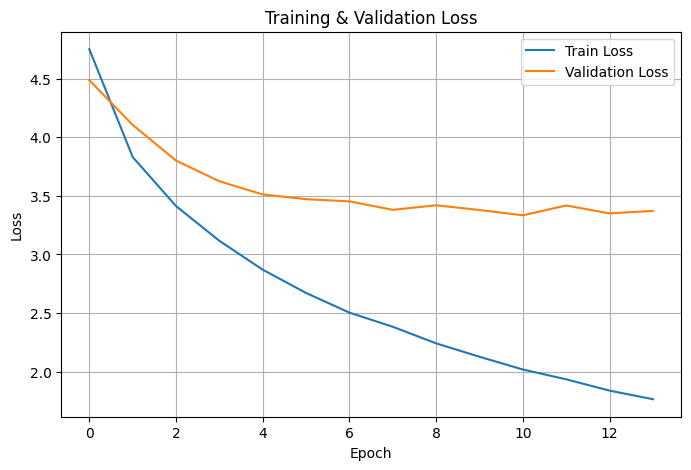

In [ ]:
def plot_losses(train_losses, val_losses):
  plt.figure(figsize=(8, 5))
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training & Validation Loss")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_losses(train_losses, val_losses)

In [ ]:
# Hàm translate
def translate(sentence, model):
  model.eval()
  source_ids = numericalize_source(sentence, tokenizer_en, vocab_en)
  source_tensor = torch.tensor(source_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
  source_lengths = torch.tensor(
    [source_tensor.size(1)],
    dtype=torch.int64
  ).cpu()
  idx_to_fr = [token for token, idx in sorted(vocab_fr.items(), key=lambda x: x[1])]

  with torch.no_grad():
    encoder_outputs, (hidden, cell) = model.encoder(source_tensor, source_lengths)
    token = torch.tensor([SOS_IDX], dtype=torch.long, device=DEVICE)

    result_tokens = []

    for _ in range(50):
      output, hidden, cell = model.decoder(token, hidden, cell)

      next_token = output.argmax(1)
      idx = next_token.item()

      if idx == EOS_IDX:
        break

      result_tokens.append(idx_to_fr[idx])
      token = next_token

  return " ".join(result_tokens)

In [ ]:
# Hàm tính BLEU
def compute_bleu(n, model, translate_method):
  smoothie = SmoothingFunction().method4
  scores = []

  for i in range(n):
    pred_sentence = translate_method(test_en_lines[i], model).lower()
    pred_tokens = pred_sentence.split()

    ref_tokens = tokenizer_fr(test_fr_lines[i].lower())

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    scores.append(bleu)

  return sum(scores) / len(scores)

print("BLEU:", compute_bleu(100, model, translate))

BLEU: 0.28775736949392344


In [43]:
# Dịch thử năm câu
for i in range(5):
    print("\nCâu thứ " + str(i + 1))
    print("=" * 50)

    print("Câu tiếng Anh gốc:")
    print(test_en_lines[i])

    print("\nCâu dự đoán do mô hình dịch:")
    print(translate(test_en_lines[i], model))

    print("\nCâu tiếng Pháp(đúng):")
    print(test_fr_lines[i])

    print("\n" + "=" * 50)


Câu thứ 1
Câu tiếng Anh gốc:
A man in an orange hat starring at something.

Câu dự đoán do mô hình dịch:
un homme avec un chapeau orange regarde quelque chose

Câu tiếng Pháp(đúng):
Un homme avec un chapeau orange regardant quelque chose.


Câu thứ 2
Câu tiếng Anh gốc:
A Boston Terrier is running on lush green grass in front of a white fence.

Câu dự đoán do mô hình dịch:
un colley tricolore court sur sur herbe verte devant un clôture vert

Câu tiếng Pháp(đúng):
Un terrier de Boston court sur l'herbe verdoyante devant une clôture blanche.


Câu thứ 3
Câu tiếng Anh gốc:
A girl in karate uniform breaking a stick with a front kick.

Câu dự đoán do mô hình dịch:
une fille en tenue de karaté avec une batte avec un objet

Câu tiếng Pháp(đúng):
Une fille en tenue de karaté brisant un bâton avec un coup de pied.


Câu thứ 4
Câu tiếng Anh gốc:
Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.

Câu dự đoán do mô hình dịch:
cinq personnes porta

Phần Nâng Cao

Thêm Cơ Chế Attention

In [44]:
class BahdanauAttention(nn.Module):
  def __init__(self, enc_dim, dec_dim):
    super().__init__()
    self.enc_proj = nn.Linear(enc_dim, dec_dim, bias=True)
    self.dec_proj = nn.Linear(dec_dim, dec_dim, bias=True)
    self.attn_score = nn.Linear(dec_dim, 1, bias=False)

  def forward(self, dec_hidden_last, enc_outputs, src_mask=None):
    # dec_hidden_last: (batch, hidden)
    # enc_outputs: (batch, src_len, hidden)

    dec_hidden_last = dec_hidden_last.unsqueeze(1)
    enc_feat = self.enc_proj(enc_outputs)
    dec_feat = self.dec_proj(dec_hidden_last)

    combined = torch.tanh(enc_feat + dec_feat)
    scores = self.attn_score(combined).squeeze(-1)

    if src_mask is not None:
      scores = scores.masked_fill(~src_mask, float("-inf"))

    attn_weights = torch.softmax(scores, dim=1)
    return attn_weights


In [45]:
class BahdanauDecoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, enc_dim, dec_dim, n_layers, dropout):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.dropout = nn.Dropout(dropout)

    self.attn = BahdanauAttention(enc_dim, dec_dim)

    self.rnn = nn.LSTM(
      emb_dim + enc_dim,
      dec_dim,
      num_layers=n_layers,
      batch_first=True,
      dropout=dropout if n_layers > 1 else 0.0
    )

    self.output_layer = nn.Linear(
      dec_dim + enc_dim + emb_dim,
      vocab_size
    )

  def forward(self, token, hidden, cell, enc_outputs, src_mask=None):
    emb = self.dropout(self.embedding(token))      # (B, emb)
    dec_query = hidden[-1]                          # (B, dec_dim)

    attn_weights = self.attn(dec_query, enc_outputs, src_mask)
    context = torch.bmm(
      attn_weights.unsqueeze(1),
      enc_outputs
    ).squeeze(1)

    rnn_input = torch.cat([emb, context], dim=-1).unsqueeze(1)
    rnn_out, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

    rnn_out = rnn_out.squeeze(1)

    logits = self.output_layer(
      torch.cat([rnn_out, context, emb], dim=-1)
    )

    return logits, hidden, cell, attn_weights


In [46]:
class Seq2SeqWithAttention(nn.Module):
  def __init__(self, encoder, decoder, pad_idx):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.pad_idx = pad_idx

  def _make_src_mask(self, src):
    return (src != self.pad_idx)

  def forward(self, src, src_len, trg, teacher_forcing=0.2):
    device = src.device
    B, T = trg.size()
    V = self.decoder.embedding.num_embeddings

    outputs = torch.zeros(B, T, V, device=device)

    enc_out, (hidden, cell) = self.encoder(src, src_len)
    src_mask = self._make_src_mask(src)

    input_tok = trg[:, 0]

    for t in range(1, T):
      pred, hidden, cell, _ = self.decoder(
        input_tok, hidden, cell, enc_out, src_mask
      )

      outputs[:, t] = pred
      use_tf = torch.rand(1).item() < teacher_forcing
      input_tok = trg[:, t] if use_tf else pred.argmax(1)

    return outputs


In [47]:
encoder = Encoder(INPUT_SIZE, ENC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
attention = BahdanauAttention(HID_SIZE, HID_SIZE).to(DEVICE)
decoder = BahdanauDecoder(OUTPUT_SIZE, DEC_EMB_SIZE, HID_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
model_with_attention = Seq2SeqWithAttention(encoder, decoder, PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model_with_attention.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [48]:
def train_epoch_attention(model, dataloader, optimizer, criterion):
  model.train()
  epoch_loss = 0

  for src, trg, src_len in dataloader:
    src, trg = src.to(DEVICE), trg.to(DEVICE)
    src_len = src_len.cpu()

    optimizer.zero_grad()

    logits = model(src, src_len, trg)
    logits = logits[:, 1:].reshape(-1, logits.size(-1))
    trg = trg[:, 1:].reshape(-1)

    loss = criterion(logits, trg)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss / len(dataloader)


In [49]:
def eval_epoch_attention(model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for source, target, source_lengths in val_loader:
      source = source.to(DEVICE)
      target = target.to(DEVICE)
      source_lengths = source_lengths.cpu()

      output = model(
          source,
          source_lengths,
          target,
          teacher_forcing_ratio=0.0
      )

      output = output[:, 1:].contiguous().view(-1, output.size(-1))
      target = target[:, 1:].contiguous().view(-1)

      loss = criterion(output, target)
      total_loss += loss.item()

    return total_loss / len(val_loader)

In [51]:
train_losses_with_attention, val_losses_with_attention = train_model(
  model=model_with_attention,
  train_epoch=lambda m: train_epoch_attention(
      m, train_loader, optimizer, criterion
  ),
  eval_epoch=lambda m: eval_epoch_attention(
      m, val_loader, criterion
  ),
  scheduler=scheduler,
  early_stopping=early_stopping,
  n_epochs=2,
  save_path="best_model_with_attention.pth"
)

TypeError: eval_epoch_attention() takes 1 positional argument but 3 were given

In [ ]:
def translate_attention(sentence, model, max_len=50):
  model.eval()

  src_ids = numericalize_source(sentence, tokenizer_en, vocab_en)
  src = torch.tensor(src_ids).unsqueeze(0).to(DEVICE)
  src_len = torch.tensor([len(src_ids)]).cpu()

  idx2tok = [w for w, _ in sorted(vocab_fr.items(), key=lambda x: x[1])]

  with torch.no_grad():
    enc_out, (hidden, cell) = model.encoder(src, src_len)
    mask = (src != PAD_IDX)

    token = torch.tensor([SOS_IDX], device=DEVICE)
    result = []

    for _ in range(max_len):
      out, hidden, cell, _ = model.decoder(
        token, hidden, cell, enc_out, mask
      )

      token = out.argmax(1)
      if token.item() == EOS_IDX:
        break

      result.append(idx2tok[token.item()])

  return " ".join(result)
